# Housing ML Notebook

https://github.com/LefanCheng/ML-Project-Predicting-Housing-Prices-Kaggle/blob/master/ML_Project_Housing_Prices_Prediction_Kaggle.ipynb

https://github.com/AidenFather/Machine-Learning-Project_Ames-House-Price-Prediction/blob/master/1_Prediction_Models.ipynb

In [1]:
# Setup Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

# Display all rows and columns
pd.set_option("display.max_columns", None)

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.ensemble import GradientBoostingRegressor
from mlxtend.regressor import StackingCVRegressor
import xgboost as xgb
import pickle

**saving models**
https://medium.com/fintechexplained/how-to-save-trained-machine-learning-models-649c3ad1c018

In [3]:
# For autoreloading modules
%load_ext autoreload
%autoreload 2

In [4]:
# # Used for auto-formatting code
# # terminal - pip install nb_black
# %load_ext nb_black

In [5]:
# Import data csvs
X = pd.read_csv("data/predictors.csv")  # id=1 to 1460
Y = pd.read_csv("data/response.csv")  # id=1461-2919

# Save figures within notebook?
save_figures = 0  # 1 (yes); 0 (no)

In [6]:
# Dummify categorical predictors
X = pd.get_dummies(X, drop_first=True)  # dummify


In [7]:
# Separate train and test.csv dataframes
train_df = X.loc[X.Id <= 1460].drop("Id", axis=1)  # train.csv
test_df = X.loc[X.Id > 1460].drop("Id", axis=1)  # test.csv
response = Y

# Test-Train split **TRAIN.CSV DATA**
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    train_df, response, test_size=0.3, random_state=0
)

## Basic Models

### Lasso Regularized Regression

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   10.5s finished


Lasso: All Features
Best Lambda:0.00012045
Train RMSE:0.10938


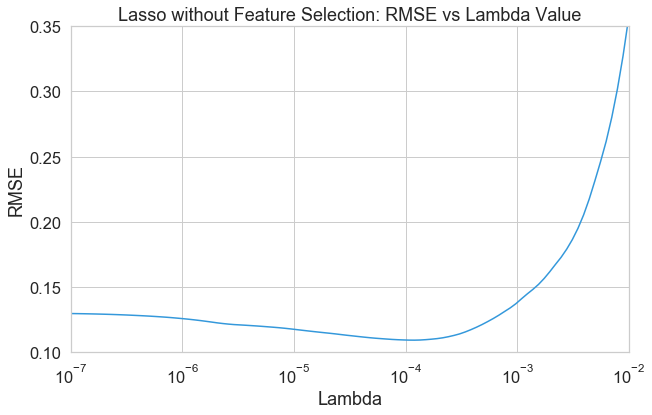

In [88]:
#New instance of model
lasso = Lasso(normalize=True, random_state=0)

#Perform gridsearch
# min_a = -7
# max_a = -2
# param_grid = {"alpha": np.logspace(min_a, max_a, 100)} #hyperparameter
param_grid = {"alpha": np.linspace(10**-5, 10**-2, 1000)}
grid = GridSearchCV(estimator=lasso, 
                    param_grid=param_grid, 
                    scoring="neg_root_mean_squared_error", #eval metric
                    verbose=True, #return status update
                    cv=5, 
                    n_jobs=-1) #create grid search
grid.fit(x_train, y_train) #fit training data to model
lasso_allFeatures = grid.best_estimator_ #assign tuned parameter to model
pickle.dump(lasso_allFeatures, open('saved_models/lasso_allFeatures', 'wb')) #save the model

# Isolate results for plot
rmse_train = -grid.best_score_  # best rmse of training dataset
print("Lasso: All Features")
print("Best Lambda:{0}".format(round(grid.best_params_["alpha"], 8)))
print("Train RMSE:{0}".format(round(rmse_train, 5)))

# Plot Lambda vs RMSE
alpha = grid.cv_results_["param_alpha"].tolist()  # for plot
rmse = (grid.cv_results_["mean_test_score"] * -1)  # for plot

plt.figure(figsize=(10, 6))
g = sns.lineplot(x=alpha, y=rmse, color="#3498db")
sns.set(style="whitegrid", font_scale=1.5)
g.set(xscale="log")
plt.xlim(10 ** min_a, 10 ** max_a)
plt.ylim(0.10, 0.350)
plt.title("Lasso without Feature Selection: RMSE vs Lambda Value")
plt.xlabel("Lambda")
plt.ylabel("RMSE")

if save_figures:
    plt.savefig("saved_figures/lasso_allFeat_RMSEvLambda.tiff", bbox_inches="tight", dpi=300)

    
#Export Data for kaggle
y_pred = lasso_allFeatures.predict(test_df) #predict submission saleprices
predict = pd.DataFrame({'Id':range(1461,2920),
                        'SalePrice': np.exp(y_pred).tolist()})
predict.to_csv('lasso_allFeat_results.csv',index=False)


### Lasso Regularized Regression with Feature Selection

Number of selected features: 81
Number of dropped features: 137


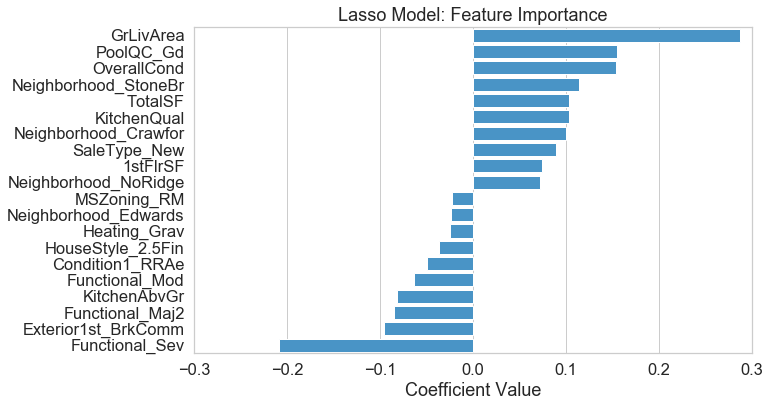

In [89]:
# Feature Selection
lasso_allFeatures.fit(x_train, y_train)  # fit model with training data
coefs_df = pd.DataFrame(lasso_allFeatures.coef_, index=x_train.columns, columns=["coef"]) #df of parameter coefficients
coefs_df.sort_values(ascending=False, by="coef", inplace=True)  # sort df
n_select = sum(coefs_df.coef != 0)  # features selected
n_drop = sum(coefs_df.coef == 0)  # features dropped
print('Number of selected features: {0}'.format(n_select))
print('Number of dropped features: {0}'.format(n_drop))

# Important features
imp_feat = coefs_df.loc[coefs_df.coef != 0].index.tolist()

# Plot coefficients of top 20 important features
plt.figure(figsize=(10, 6))
data = pd.concat([coefs_df.head(10), coefs_df.tail(10)], axis=0)
sns.barplot(x=data.coef, y=data.index, color="#3498db")
sns.set(style="whitegrid", font_scale=1.5)
plt.title("Lasso Model: Feature Importance")
plt.xlabel("Coefficient Value")
plt.xlim(-0.3, 0.3)

if save_figures:
    plt.savefig("saved_figures/lasso_feat_importance.tiff", bbox_inches="tight")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.4s finished


Lasso: All Features
Best Lambda:1.322e-05
Train RMSE:0.10371


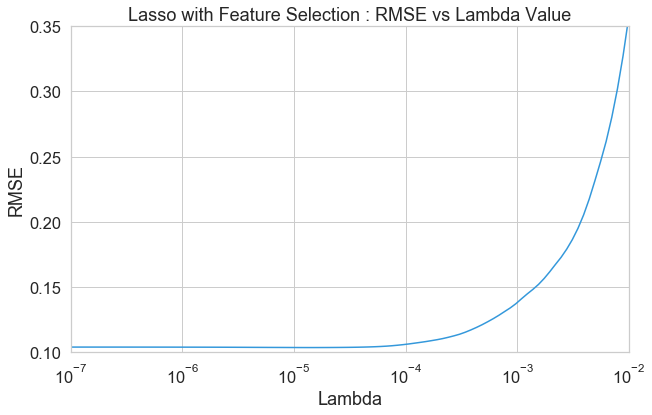

In [90]:
#New instance of model
lasso = Lasso(normalize=True, random_state=0)

#Perform gridsearch
# min_a = -7
# max_a = -2
# param_grid = {"alpha": np.logspace(min_a, max_a, 100)} #hyperparameter
param_grid = {"alpha": np.linspace(10**-7, 10**-5, 1000)} #hyperparameter
grid = GridSearchCV(estimator=lasso, 
                    param_grid=param_grid, 
                    scoring="neg_root_mean_squared_error", #eval metric
                    verbose=True, #return status update
                    cv=5, 
                    n_jobs=-1) #create grid search
grid.fit(x_train[imp_feat], y_train) #fit training data to model
lasso_selectFeatures = grid.best_estimator_ #assign tuned parameter to model
pickle.dump(lasso_selectFeatures, open('saved_models/lasso_selectFeatures', 'wb')) #save the model

# Isolate results for plot
rmse_train = -grid.best_score_  # best rmse of training dataset
print("Lasso: All Features")
print("Best Lambda:{0}".format(round(grid.best_params_["alpha"], 8)))
print("Train RMSE:{0}".format(round(rmse_train, 5)))

# Plot Lambda vs RMSE
alpha = grid.cv_results_["param_alpha"].tolist()  # for plot
rmse = (grid.cv_results_["mean_test_score"] * -1)  # for plot

plt.figure(figsize=(10, 6))
g = sns.lineplot(x=alpha, y=rmse, color="#3498db")
sns.set(style="whitegrid", font_scale=1.5)
g.set(xscale="log")
plt.xlim(10 ** min_a, 10 ** max_a)
plt.ylim(0.10, 0.350)
plt.title("Lasso with Feature Selection : RMSE vs Lambda Value")
plt.xlabel("Lambda")
plt.ylabel("RMSE")

if save_figures:
    plt.savefig("saved_figures/lasso_selectFeat_RMSEvLambda.tiff", bbox_inches="tight", dpi=300)

    
#Export Data for kaggle
y_pred = lasso_selectFeatures.predict(test_df[imp_feat]) #predict submission saleprices
predict = pd.DataFrame({'Id':range(1461,2920),
                        'SalePrice': np.exp(y_pred).tolist()})
predict.to_csv('saved_predictions/lasso_selectFeat_results.csv',index=False)

### Ridge Regularized Regression


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.1s finished


Ridge: All Features
Best Lambda:0.2009233
Train RMSE:0.113


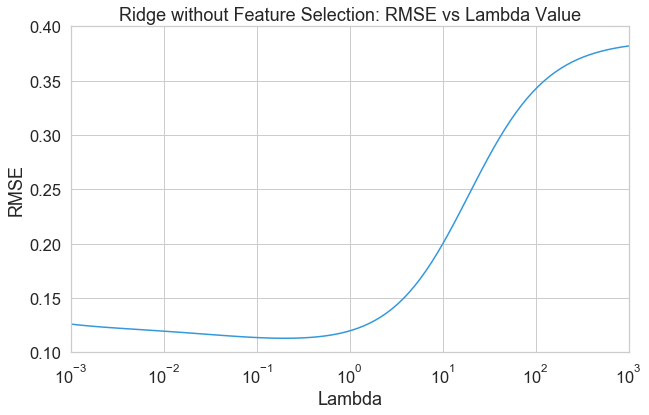

In [92]:
#New instance of model
ridge = Ridge(normalize=True, random_state=0)

#Perform gridsearch
# min_a = -3
# max_a = 3
# param_grid = {"alpha": np.logspace(min_a, max_a, 100)} #hyperparameter

param_grid = {"alpha": np.linspace(-1, 1, 1000)} #hyperparameter
grid = GridSearchCV(estimator=ridge, 
                    param_grid=param_grid, 
                    scoring="neg_root_mean_squared_error", #eval metric
                    verbose=True, #return status update
                    cv=5, 
                    n_jobs=-1) #create grid search
grid.fit(x_train, y_train) #fit training data to model
ridge_allFeatures = grid.best_estimator_ #assign tuned parameter to model
pickle.dump(ridge_allFeatures, open('saved_models/ridge_allFeatures', 'wb')) #save the model

# Isolate results for plot
rmse_train = -grid.best_score_  # best rmse of training dataset
print("Ridge: All Features")
print("Best Lambda:{0}".format(round(grid.best_params_["alpha"], 8)))
print("Train RMSE:{0}".format(round(rmse_train, 5)))

# Plot Lambda vs RMSE
alpha = grid.cv_results_["param_alpha"].tolist()  # for plot
rmse = (grid.cv_results_["mean_test_score"] * -1)  # for plot

plt.figure(figsize=(10, 6))
g = sns.lineplot(x=alpha, y=rmse, color="#3498db")
sns.set(style="whitegrid", font_scale=1.5)
g.set(xscale="log")
plt.xlim(10 ** min_a, 10 ** max_a)
plt.ylim(0.10, 0.40)
plt.title("Ridge without Feature Selection: RMSE vs Lambda Value")
plt.xlabel("Lambda")
plt.ylabel("RMSE")

if save_figures:
    plt.savefig("saved_figures/ridge_allFeat_RMSEvLambda.tiff", bbox_inches="tight", dpi=300)

    
#Export Data for kaggle
y_pred = ridge_allFeatures.predict(test_df).squeeze() #predict submission saleprices
predict = pd.DataFrame({'Id':range(1461,2920),
                        'SalePrice': np.exp(y_pred).tolist()})
predict.to_csv('saved_predictions/ridge_allFeat_results.csv',index=False)


### Ridge Regularized Regression with Feature Selection
- Feature importance determined with Lasso model

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


Ridge: Selected Features
Best Lambda:0.03764936
Train RMSE:0.10355


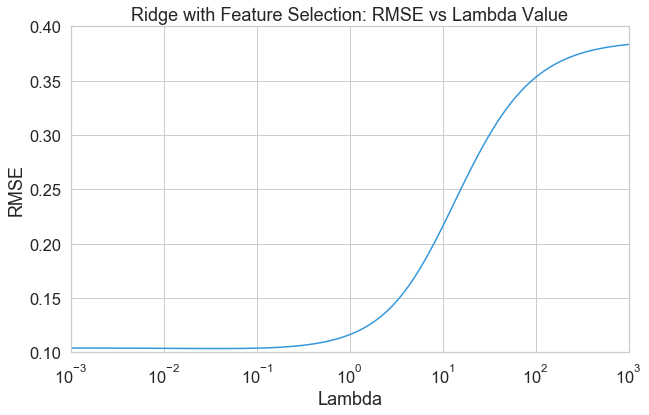

In [93]:
#New instance of model
ridge = Ridge(normalize=True, random_state=0)

#Perform gridsearch
# min_a = -3
# max_a = 3
# param_grid = {"alpha": np.logspace(min_a, max_a, 100)} #hyperparameter


param_grid = {"alpha": np.logspace(-1, 1, 1000)} #hyperparameter
grid = GridSearchCV(estimator=ridge, 
                    param_grid=param_grid, 
                    scoring="neg_root_mean_squared_error", #eval metric
                    verbose=True, #return status update
                    cv=5, 
                    n_jobs=-1) #create grid search
grid.fit(x_train[imp_feat], y_train) #fit training data to model
ridge_selectFeatures = grid.best_estimator_ #assign tuned parameter to model
pickle.dump(ridge_selectFeatures, open('saved_models/ridge_selectFeatures', 'wb')) #save the model

# Isolate results for plot
rmse_train = -grid.best_score_  # best rmse of training dataset
print("Ridge: Selected Features")
print("Best Lambda:{0}".format(round(grid.best_params_["alpha"], 8)))
print("Train RMSE:{0}".format(round(rmse_train, 5)))

# Plot Lambda vs RMSE
alpha = grid.cv_results_["param_alpha"].tolist()  # for plot
rmse = (grid.cv_results_["mean_test_score"] * -1)  # for plot

plt.figure(figsize=(10, 6))
g = sns.lineplot(x=alpha, y=rmse, color="#3498db")
sns.set(style="whitegrid", font_scale=1.5)
g.set(xscale="log")
plt.xlim(10 ** min_a, 10 ** max_a)
plt.ylim(0.10, 0.40)
plt.title("Ridge with Feature Selection: RMSE vs Lambda Value")
plt.xlabel("Lambda")
plt.ylabel("RMSE")

if save_figures:
    plt.savefig("saved_figures/ridge_selectFeat_RMSEvLambda.tiff", bbox_inches="tight", dpi=300)

    
#Export Data for kaggle
y_pred = ridge_selectFeatures.predict(test_df[imp_feat]).squeeze() #predict submission saleprices
predict = pd.DataFrame({'Id':range(1461,2920),
                        'SalePrice': np.exp(y_pred).tolist()})
predict.to_csv('saved_predictions/ridge_selectFeat_results.csv',index=False)


### ElasticNet Regularized Regression 

In [94]:
#New instance of model
elastic = ElasticNet(normalize=True, random_state=0)

# #Perform gridsearch
# min_a = -7
# max_a = -2
# param_grid = {"alpha": np.logspace(min_a, max_a, 100)} #hyperparameter



param_grid = {'alpha': np.linspace(10**-5, 10**-2, 600),
              'l1_ratio': [x / 100 for x in range(55, 75, 1)]}
grid = GridSearchCV(estimator=elastic, 
                    param_grid=param_grid, 
                    scoring="neg_root_mean_squared_error", #eval metric
                    verbose=True, #return status update
                    cv=5, 
                    n_jobs=-1) #create grid search
grid.fit(x_train, y_train) #fit training data to model
elastic_allFeatures = grid.best_estimator_ #assign tuned parameter to model
pickle.dump(elastic_allFeatures, open('saved_models/elastic_allFeatures', 'wb')) #save the model

# Isolate results for plot
rmse_train = -grid.best_score_  # best rmse of training dataset
print("ElasticNet: All Features")
print("Best Lambda:{0}".format(round(grid.best_params_["alpha"], 8)))
print("Train RMSE:{0}".format(round(rmse_train, 5)))

#Export Data for kaggle
y_pred = elastic_allFeatures.predict(test_df) #predict submission saleprices
predict = pd.DataFrame({'Id':range(1461,2920),
                        'SalePrice': np.exp(y_pred).tolist()})
predict.to_csv('saved_predictions/elastic_allFeat_results.csv',index=False)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.8s


ElasticNet: All Features
Best Lambda:0.00019179
Train RMSE:0.10914


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    7.8s finished


### Gradient Boosting Regression

In [96]:
# New instance of model
gb_model = GradientBoostingRegressor(random_state=0)

#Perform randomized search due to numbe of hyperparameters
param_grid = {'learning_rate': np.linspace(0.01, 1, 20),
              'loss': ['ls','huber'],
              'max_depth': range(2,11,2), #max depth of tree
              'max_features': ['sqrt','log2'], #n for considering a best split
              'min_samples_leaf': range(1,10,2),
              'min_samples_split': range(1,31, 5),
              'n_estimators': range(100,3500, 100)
             }

grid = RandomizedSearchCV(estimator=gb_model,
                          param_distributions=param_grid, 
                          n_iter=2000, #n parameter settings sampled
                          scoring="neg_root_mean_squared_error", #eval metric
                          verbose=True, #return status update
                          cv=5,
                          n_jobs=-1)
grid.fit(x_train, y_train) #fit training data to model
gb_allFeatures = grid.best_estimator_ #assign tuned parameter to model
pickle.dump(gb_allFeatures, open('saved_models/gb_allFeatures', 'wb')) #save the model


# Print results
rmse_train = -grid.best_score_  # best rmse of training dataset

print("XGB: All Features")
print("Best learning_rate:{0}".format(round(grid.best_params_["learning_rate"], 8)))
print("Best loss:{0}".format(grid.best_params_["loss"]))
print("Best max_depth:{0}".format(round(grid.best_params_["max_depth"], 8)))
print("Best max_features:{0}".format(grid.best_params_["max_features"]))
print("Best min_samples_leaf:{0}".format(round(grid.best_params_["min_samples_leaf"], 8)))
print("Best min_samples_split:{0}".format(round(grid.best_params_["min_samples_split"], 8)))
print("Best n_estimators:{0}".format(round(grid.best_params_["n_estimators"], 8)))
print("Train RMSE:{0}".format(round(rmse_train, 5)))

# Export Data for kaggle
y_pred = gb_allFeatures.predict(test_df)
predict = pd.DataFrame({"Id": range(1461, 2920),
                        "SalePrice": np.exp(y_pred).tolist()})
predict.to_csv("saved_predictions/gb_allFeatures_results.csv", index=False)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   13.8s finished


XGB: All Features
Best learning_rate:0.01
Best loss:ls
Best max_depth:4
Best max_features:log2
Best min_samples_leaf:9
Best min_samples_split:6
Best n_estimators:2700
Train RMSE:0.10998


### XGBoost Regression

In [98]:
# New instance of model
xgb_model = xgb.XGBRegressor(normalize=True, 
                             random_state=0, 
                             objective ='reg:squarederror')

#Perform randomized search due to numbe of hyperparameters
param_grid = {'alpha': np.linspace(0.01, 1, 20), #L1 Lasso regularization
              'colsample_bytree': np.linspace(0.01, 1, 20), #frac of col. used per tree
              'eta': np.linspace(0.01, 1, 20), # learning rate
              'gamma': np.linspace(0.01, 1, 20), #specifies min loss reduction for split
              'lambda': np.linspace(0.01, 1, 20), #L2 Ridge regularization
              'max_depth': range(2,11,2), #max depth of tree
              'min_child_weight': [1, 1.5, 1.75, 2, 3], #min sum weights required in child
              'subsample': np.linspace(0.01, 1, 20), #frac of obvs. randomly sampled per tree
              'n_estimators': range(50,1500, 50), #number of trees
             }
grid = RandomizedSearchCV(estimator=xgb_model,
                          param_distributions=param_grid, 
                          n_iter=2000, #n parameter settings sampled
                          scoring="neg_root_mean_squared_error", #eval metric
                          verbose=True, #return status update
                          cv=5,
                          n_jobs=-1)
grid.fit(x_train, y_train) #fit training data to model
xgb_allFeatures = grid.best_estimator_ #assign tuned parameter to model
pickle.dump(xgb_allFeatures, open('saved_models/xgb_allFeatures', 'wb')) #save the model


# Print results
rmse_train = -grid.best_score_  # best rmse of training dataset

print("XGB: All Features")
print("Best alpha:{0}".format(round(grid.best_params_["alpha"], 8)))
print("Best colsample_bytree:{0}".format(round(grid.best_params_["colsample_bytree"], 8)))
print("Best eta:{0}".format(round(grid.best_params_["eta"], 8)))
print("Best gamma:{0}".format(round(grid.best_params_["gamma"], 8)))
print("Best max_depth:{0}".format(round(grid.best_params_["max_depth"], 8)))
print("Best min_child_weight:{0}".format(round(grid.best_params_["min_child_weight"], 8)))
print("Best n_estimators:{0}".format(round(grid.best_params_["n_estimators"], 8)))
print("Best subsample:{0}\n".format(round(grid.best_params_["subsample"], 8)))
print("Train RMSE:{0}".format(round(rmse_train, 5)))

# Export Data for kaggle
y_pred = xgb_allFeatures.predict(test_df)
predict = pd.DataFrame({"Id": range(1461, 2920),
                        "SalePrice": np.exp(y_pred).tolist()})
predict.to_csv("saved_predictions/xgb_allFeatures_results.csv", index=False)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   46.2s finished


XGB: All Features
Best alpha:0.42684211
Best colsample_bytree:0.11421053
Best eta:0.89578947
Best gamma:0.06210526
Best max_depth:4
Best min_child_weight:1.5
Best n_estimators:1250
Best subsample:0.58315789

Train RMSE:0.11553


## Higher Level Models

### Average Model

In [99]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 

In [160]:
avg_stack_model = AveragingModels(models = (lasso_allFeatures, 
                                            ridge_allFeatures, 
                                            elastic_allFeatures, 
                                            gb_allFeatures, 
                                            xgb_allFeatures))

# Train model
avg_stack_model.fit(train_df, response)

# Assess performance
from preprocess_module import calc_rmse
rmse_train, error_train = calc_rmse(avg_stack_model, train_df, response)
print("Train RMSE:{0}".format(round(rmse_train, 5)))
print("Mean Error: ${0}".format(round(error_train, 2)))
y_pred = avg_stack_model.predict(test_df)

# Export Data for kaggle
y_pred = avg_stack_model.predict(test_df)
predict = pd.DataFrame({"Id": range(1461, 2920),
                        "SalePrice": np.exp(y_pred).tolist()})
predict.to_csv("saved_predictions/avg_stack_results.csv", index=False)


Train RMSE:0.10538
Mean Error: $69558.06


### StackedRegressor: Lasso Meta-Regressor

In [177]:
stack_reg_lasso_model = StackingCVRegressor(regressors=(lasso_allFeatures,
                                                        ridge_allFeatures,
                                                        elastic_allFeatures,
                                                        gb_allFeatures,
                                                        xgb_allFeatures),
                                      meta_regressor=lasso_allFeatures,
                                      random_state=0, 
                                      use_features_in_secondary=True)


print('5-fold cross validation scores:\n')
for clf, label in zip([lasso_allFeatures, 
                       ridge_allFeatures, 
                       elastic_allFeatures, 
                       gb_allFeatures,
                       xgb_allFeatures, 
                       stack_reg_lasso_model], ['Lasso',
                                                'Ridge',
                                                'ElasticNet',
                                                'GradientBoost',
                                                'XGBoost',
                                                'StackingCVRegressor']):
    scores = cross_val_score(clf, np.array(train_df), np.array(response), cv=5, scoring='neg_root_mean_squared_error')
    print("RMSE Score:{0} [{1}]".format(round(-scores.mean(),5), label))

# Train model
stack_reg_lasso_model.fit(np.array(train_df), np.array(response))
y_pred = stack_reg_lasso_model.predict(np.array(train_df))

# Export Data for kaggle
y_pred = stack_reg_lasso_model.predict(np.array(test_df))
predict = pd.DataFrame({"Id": range(1461, 2920),
                        "SalePrice": np.exp(y_pred).tolist()})
predict.to_csv("saved_predictions/stack_reg_lasso_results.csv", index=False)


5-fold cross validation scores:

RMSE Score:0.1076 [Lasso]
RMSE Score:0.1122 [Ridge]
RMSE Score:0.1082 [ElasticNet]
RMSE Score:0.10741 [GradientBoost]
RMSE Score:0.11054 [XGBoost]
RMSE Score:0.1053 [StackingCVRegressor]


### StackedRegressor: XGBoost Meta-Regressor

In [ ]:
stack_reg_xgb_model = StackingCVRegressor(regressors=(lasso_allFeatures,
                                                        ridge_allFeatures,
                                                        elastic_allFeatures,
                                                        gb_allFeatures,
                                                        xgb_allFeatures),
                                      meta_regressor=xgb_allFeatures,
                                      random_state=0, 
                                      use_features_in_secondary=True)


print('5-fold cross validation scores:\n')
for clf, label in zip([lasso_allFeatures, 
                       ridge_allFeatures, 
                       elastic_allFeatures, 
                       gb_allFeatures,
                       xgb_allFeatures, 
                       stack_reg_xgb_model], ['Lasso',
                                              'Ridge',
                                              'ElasticNet',
                                              'GradientBoost',
                                              'XGBoost',
                                              'StackingCVRegressor']):
    scores = cross_val_score(clf, np.array(train_df), np.array(response), cv=5, scoring='neg_root_mean_squared_error')
    print("RMSE Score:{0} [{1}]".format(round(-scores.mean(),5), label))

# Train model
stack_reg_xgb_model.fit(np.array(train_df), np.array(response))
y_pred = stack_reg_xgb_model.predict(np.array(train_df))

# Export Data for kaggle
y_pred = stack_reg_xgb_model.predict(np.array(test_df))
predict = pd.DataFrame({"Id": range(1461, 2920),
                        "SalePrice": np.exp(y_pred).tolist()})
predict.to_csv("saved_predictions/stack_reg_xgb_model.csv", index=False)



### Model Tuning of Only Selected Features

In [ ]:
# Isolate all important features
imp_feat = coefs_df.loc[coefs_df.coef != 0].index.tolist()

# Input for CV
min_a = -7  # used for plot
max_a = -2  # used for plot
param_grid = {"alpha": np.logspace(min_a, max_a, 1000)}

# Instantiate model, cross validation, and grid search
grid = GridSearchCV(estimator=lasso, 
                    param_grid=param_grid, 
                    scoring="neg_root_mean_squared_error", #eval metric
                    verbose=True, #return status update
                    cv=cv, 
                    n_jobs=-1)

lasso_selectFeat = grid.fit(x_train[imp_feat], y_train) #fit training data to model

# Isolate results
lasso_selectFeat_alpha = lasso_selectFeat.cv_results_["param_alpha"].tolist()  # list of all alphas
rmse = (lasso_selectFeat.cv_results_["mean_test_score"] * -1)  # list of mean rmse of training data
rmse_train = -lasso_selectFeat.best_score_  # best rmse of training dataset

# Fit test data to model
lasso_selectFeat_model = lasso_selectFeat.best_estimator_
pickle.dump(lasso_selectFeat_model, open('saved_models/lasso_Feat_model', 'wb')) #save the model
y_pred = lasso_selectFeat_model.predict(x_test[imp_feat])  # GridSearchCV uses best parameters
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

# Print results
print("Lasso: All Features")
print("Best Lambda:{0}".format(round(lasso_selectFeat.best_params_["alpha"], 8)))
print("Train RMSE:{0}".format(round(rmse_train, 5)))
print("Test RMSE:{0}\n".format(round(rmse_test, 5)))

# Plot Lambda vs RMSE
plt.figure(figsize=(10, 6))
g = sns.lineplot(x=lasso_selectFeat_alpha, y=rmse, color="#3498db")
sns.set(style="whitegrid", font_scale=1.5)
g.set(xscale="log")
plt.xlim(10 ** min_a, 10 ** max_a)
plt.ylim(0.10, 0.350)
plt.title("Lasso (Selected Features): RMSE vs Lambda Value")
plt.xlabel("Lambda")
plt.ylabel("RMSE")

if save_figures:
    plt.savefig("saved_figures/lasso_selectFeat_RMSEvLambda.tiff", bbox_inches="tight", dpi=300)

#Export Data for kaggle
y_pred = lasso_selectFeat_model.predict(test_df[imp_feat])
predict = pd.DataFrame({'Id':range(1461,2920),
                        'SalePrice': np.exp(y_pred).tolist()})
predict.to_csv('lasso_selectFeat.csv',index=False)


## RIDGE REGRESSION

### Ridge Before Feature Selection

In [ ]:
# Input for CV
min_a = -3  # used for plot
max_a = 3  # used for plot
param_grid = {"alpha": np.logspace(min_a, max_a,100)}

# Instantiate model, cross validation, and grid search
ridge = Ridge(normalize=True, random_state=0)
cv = KFold(5, shuffle=True, random_state=0)
grid = GridSearchCV(estimator=ridge,
                    param_grid=param_grid, 
                    scoring="neg_root_mean_squared_error", #eval metric
                    verbose=True, #return status update
                    cv=cv,
                    n_jobs=-1)

ridge_allFeat = grid.fit(x_train, y_train) #fit training data to model

# Isolate results
ridge_allFeat_alpha = ridge_allFeat.cv_results_["param_alpha"].tolist()  # list of all alphas
rmse = (ridge_allFeat.cv_results_["mean_test_score"] * -1)  # list of mean rmse of training data
rmse_train = -ridge_allFeat.best_score_  # best rmse of training dataset

# Fit test data to model
ridge_allFeat_model = ridge_allFeat.best_estimator_
pickle.dump(ridge_allFeat_model, open('saved_models/ridge_allFeat_model', 'wb')) #save the model
y_pred = ridge_allFeat_model.predict(x_test)  # GridSearchCV uses best parameters
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

# Print results
print("Ridge: All Features")
print("Best Lambda:{0}".format(round(ridge_allFeat.best_params_["alpha"], 8)))
print("Train RMSE:{0}".format(round(rmse_train, 5)))
print("Test RMSE:{0}\n".format(round(rmse_test, 5)))


# Plot Lambda vs RMSE
plt.figure(figsize=(10, 6))
g = sns.lineplot(x=ridge_allFeat_alpha, y=rmse, color="#3498db")
sns.set(style="whitegrid", font_scale=1.5)
g.set(xscale="log")
plt.xlim(10 ** min_a, 10 ** max_a)
plt.ylim(0.10, 0.4)
plt.title("Ridge (All Features): RMSE vs Lambda Value")
plt.xlabel("Lambda")
plt.ylabel("RMSE")

if save_figures:
    plt.savefig("saved_figures/ridge_allFeat_RMSEvLambda.tiff", bbox_inches="tight", dpi=300)

    
#Export Data for kaggle
y_pred = ridge_allFeat_model.predict(test_df)
predict = pd.DataFrame({'Id':range(1461,2920),
                        'SalePrice': np.exp(y_pred).tolist()})
predict.to_csv('ridge_allFeat.csv',index=False)


### Ridge After Feature Selection

In [ ]:
# Input for CV
min_a = -3  # used for plot
max_a = 3  # used for plot
param_grid = {"alpha": np.logspace(min_a, max_a, 1000)}

# Instantiate model, cross validation, and grid search
ridge = Ridge(normalize=True, random_state=0)
cv = KFold(5, shuffle=True, random_state=0)
grid = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",  # eval metric
    verbose=True,  # return status update
    cv=cv,
    n_jobs=-1,
)

ridge_selectFeat = grid.fit(x_train[imp_feat], y_train)  # fit training data to model

# Isolate results
ridge_selectFeat_alpha = ridge_selectFeat.cv_results_["param_alpha"].tolist()  # list of all alphas
rmse = (ridge_selectFeat.cv_results_["mean_test_score"] * -1)  # list of mean rmse of training data
rmse_train = -ridge_selectFeat.best_score_  # best rmse of training dataset

# Fit test data to model
ridge_selectFeat_model = ridge_selectFeat.best_estimator_
pickle.dump(ridge_selectFeat_model, open('saved_models/ridge_selectFeat_model', 'wb')) #save the model
y_pred = ridge_selectFeat_model.predict(x_test[imp_feat])  # GridSearchCV uses best parameters
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

# Print results
print("Ridge: Select Features")
print("Best Lambda:{0}".format(round(ridge_selectFeat.best_params_["alpha"], 8)))
print("Train RMSE:{0}".format(round(rmse_train, 5)))
print("Test RMSE:{0}\n".format(round(rmse_test, 5)))

# Plot Lambda vs RMSE
plt.figure(figsize=(10, 6))
g = sns.lineplot(x=ridge_selectFeat_alpha, y=rmse, color="#3498db")
sns.set(style="whitegrid", font_scale=1.5)
g.set(xscale="log")
plt.xlim(10 ** min_a, 10 ** max_a)
plt.ylim(0.10, 0.4)
plt.title("Ridge (Select Features): RMSE vs Lambda Value")
plt.xlabel("Lambda")
plt.ylabel("RMSE")

if save_figures:
    plt.savefig("saved_figures/ridge_selectFeat_RMSEvLambda.tiff", bbox_inches="tight", dpi=300)

# Export Data for kaggle
y_pred = ridge_selectFeat_model.predict(test_df[imp_feat])
predict = pd.DataFrame({"Id": range(1461, 2920), "SalePrice": np.exp(y_pred).tolist()})
predict.to_csv("ridge_selectFeat.csv", index=False)


## ELASTIC-NET REGRESSION

### Elastic-Net Before Feature Selection

In [8]:
# Input for CV
min_a = -6  # used for plot
max_a = 2  # used for plot
param_grid = {'alpha': np.logspace(min_a, max_a, 50),
              'l1_ratio': [x / 100 for x in range(5, 105, 10)]}

# Instantiate model, cross validation, and grid search
elastic = ElasticNet(normalize=True, random_state=0)
cv = KFold(5, shuffle=True, random_state=0)
grid = GridSearchCV(estimator=elastic,
                    param_grid=param_grid, 
                    scoring="neg_root_mean_squared_error", #eval metric
                    verbose=True, #return status update
                    cv=cv,
                    n_jobs=-1)

elastic_allFeat = grid.fit(x_train, y_train) #fit training data to model

# Isolate results
elastic_allFeat_alpha = elastic_allFeat.cv_results_["param_alpha"].tolist()  # list of all alphas
elastic_allFeat_rho = elastic_allFeat.cv_results_["param_l1_ratio"].tolist()  # list of all alphas
rmse = (elastic_allFeat.cv_results_["mean_test_score"] * -1)  # list of mean rmse of training data
rmse_train = -elastic_allFeat.best_score_  # best rmse of training dataset

# Fit test data to model
elastic_allFeat_model = elastic_allFeat.best_estimator_
pickle.dump(elastic_allFeat_model, open('saved_models/elastic_allFeat_model', 'wb')) #save the model
y_pred = elastic_allFeat_model.predict(x_test)  # GridSearchCV uses best parameters
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

# Print results
print("ElasticNet: All Features")
print("Best Lambda:{0}".format(round(elastic_allFeat.best_params_["alpha"], 8)))
print("Best Lambda:{0}".format(round(elastic_allFeat.best_params_["l1_ratio"],3)))
print("Train RMSE:{0}".format(round(rmse_train, 5)))
print("Test RMSE:{0}\n".format(round(rmse_test, 5)))

    
# Export Data for kaggle
y_pred = elastic_allFeat_model.predict(test_df)
predict = pd.DataFrame({"Id": range(1461, 2920),
                        "SalePrice": np.exp(y_pred).tolist()})
predict.to_csv("elastic_allFeat.csv", index=False)


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 485 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 2485 out of 2500 | elapsed:   17.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:   17.8s finished


ElasticNet: All Features
Best Lambda:0.00019307
Best Lambda:0.65
Train RMSE:0.11128
Test RMSE:0.10532



### Elastic-Net After Feature Selection

In [ ]:
# Input for CV
min_a = -6  # used for plot
max_a = 6  # used for plot
param_grid = {'alpha': np.logspace(min_a, max_a, 600),
              'l1_ratio': [x / 1000 for x in range(0, 105, 5)]}

# Instantiate model, cross validation, and grid search
elastic = ElasticNet(normalize=True, random_state=0)
cv = KFold(5, shuffle=True, random_state=0)
grid = GridSearchCV(estimator=elastic,
                    param_grid=param_grid, 
                    scoring="neg_root_mean_squared_error", #eval metric
                    verbose=True, #return status update
                    cv=cv,
                    n_jobs=-1)

elastic_selectFeat = grid.fit(x_train[imp_feat], y_train) #fit training data to model

# Isolate results
elastic_selectFeat_alpha = elastic_selectFeat.cv_results_["param_alpha"].tolist()  # list of all alphas
elastic_selectFeat_rho = elastic_selectFeat.cv_results_["param_l1_ratio"].tolist()  # list of all alphas
rmse = (elastic_selectFeat.cv_results_["mean_test_score"] * -1)  # list of mean rmse of training data
rmse_train = -elastic_selectFeat.best_score_  # best rmse of training dataset

# Fit test data to model
elastic_selectFeat_model = elastic_selectFeat.best_estimator_
pickle.dump(elastic_selectFeat_model, open('saved_models/elastic_selectFeat_model', 'wb')) #save the model
y_pred = elastic_selectFeat_model.predict(x_test[imp_feat])  # GridSearchCV uses best parameters
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

# Print results
print("ElasticNet: Select Features")
print("Best Lambda:{0}".format(round(elastic_selectFeat.best_params_["alpha"], 8)))
print("Best Lambda:{0}\n".format(round(elastic_selectFeat.best_params_["l1_ratio"],3)))
print("Train RMSE:{0}".format(round(rmse_train, 5)))
print("Test RMSE:{0}\n".format(round(rmse_test, 5)))

    
# Export Data for kaggle
y_pred = elastic_selectFeat_model.predict(test_df[imp_feat])
predict = pd.DataFrame({"Id": range(1461, 2920),
                        "SalePrice": np.exp(y_pred).tolist()})
predict.to_csv("elastic_selectFeat.csv", index=False)

## eXtremeGradientBoost Regression


### XGBoost Before Feature Selection

In [ ]:
#Input for CV
param_grid = {'alpha': np.linspace(0.01, 1, 20), #L1 Lasso regularization
              'colsample_bytree': np.linspace(0.01, 1, 20), #frac of col. used per tree
              'eta': np.linspace(0.01, 1, 20), # learning rate
              'gamma': np.linspace(0.01, 1, 20), #specifies min loss reduction for split
              'lambda': np.linspace(0.01, 1, 20), #L2 Ridge regularization
              'max_depth': range(2,11,2), #max depth of tree
              'min_child_weight': [1, 1.5, 1.75, 2, 3], #min sum weights required in child
              'subsample': np.linspace(0.01, 1, 20), #frac of obvs. randomly sampled per tree
              'n_estimators': range(50,1500, 50), #number of trees
             }

# param_grid = {'alpha': [0.1], #L1 Lasso regularization
#               'colsample_bytree': [0.775], #frac of col. used per tree
#               'eta': [.01], # learning rate
#               'gamma': [.01], #specifies min loss reduction for split
#               'lambda': [0.1], #L2 Ridge regularization
#               'max_depth': [3], #max depth of tree
#               'min_child_weight': [1.8], #min sum weights required in child
#               'subsample': [0.775], #frac of obvs. randomly sampled per tree
#               'n_estimators': [300], #number of trees
#              }

# Instantiate model, cross validation, and grid search
xgb_model = xgb.XGBRegressor(normalize=True, random_state=0, objective ='reg:squarederror')
cv = KFold(5, shuffle=True, random_state=0)
grid = RandomizedSearchCV(estimator=xgb_model,
                          param_distributions=param_grid, 
                          n_iter=100, #n parameter settings sampled
                          scoring="neg_root_mean_squared_error", #eval metric
                          verbose=True, #return status update
                          cv=cv,
                          n_jobs=-1)

xgb_allFeat = grid.fit(x_train, y_train) #fit training data to model

# Isolate results
rmse_train = -xgb_allFeat.best_score_  # best rmse of training dataset

# Fit test data to model
xgb_allFeat_model = xgb_allFeat.best_estimator_
pickle.dump(xgb_allFeat_model, open('saved_models/xgb_allFeat_model', 'wb')) #save the model
y_pred = xgb_allFeat_model.predict(x_test)  # GridSearchCV uses best parameters
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

# # Print results
print("XGB: All Features")
print("Best alpha:{0}".format(round(xgb_allFeat.best_params_["alpha"], 8)))
print("Best colsample_bytree:{0}".format(round(xgb_allFeat.best_params_["colsample_bytree"], 8)))
print("Best eta:{0}".format(round(xgb_allFeat.best_params_["eta"], 8)))
print("Best gamma:{0}".format(round(xgb_allFeat.best_params_["gamma"], 8)))
print("Best max_depth:{0}".format(round(xgb_allFeat.best_params_["max_depth"], 8)))
print("Best min_child_weight:{0}".format(round(xgb_allFeat.best_params_["min_child_weight"], 8)))
print("Best n_estimators:{0}".format(round(xgb_allFeat.best_params_["n_estimators"], 8)))
print("Best subsample:{0}\n".format(round(xgb_allFeat.best_params_["subsample"], 8)))
print("Train RMSE:{0}".format(round(rmse_train, 5)))
print("Test RMSE:{0}\n".format(round(rmse_test, 5)))

# Export Data for kaggle
y_pred = xgb_allFeat_model.predict(test_df)
predict = pd.DataFrame({"Id": range(1461, 2920),
                        "SalePrice": np.exp(y_pred).tolist()})
predict.to_csv("xgb_allFeat.csv", index=False)

# ==========================================
# Single Value Group
# Train RMSE:0.11515
# Test RMSE:0.10895

### Feature Importance

In [ ]:
# Instantiate model
xgb_allFeat_model.fit(x_train, y_train) #fit model with train data

#Plot Feature Importance
imp_dict = xgb_allFeat_model.get_booster().get_score(importance_type='gain') #gain=largest contribution to decision
imp_df = [[x, imp_dict[x]] for x in imp_dict.keys()]
imp_df = pd.DataFrame(imp_df, columns=['feature','fscore'])
imp_df.sort_values(ascending=False, by='fscore', inplace=True)
top_imp_df = imp_df.iloc[:20] #top 20 features
             
plt.figure(figsize=(10, 6))
sns.barplot(data=top_imp_df,
            y='feature',
            x='fscore', 
            color="#3498db")
sns.set(style="whitegrid", font_scale=1.5)
plt.title("XGBoost Model: Feature Importance")
plt.xlabel("F-Score")
plt.ylabel("")
plt.xlim(0,1.6)

if save_figures:
    plt.savefig("saved_figures/xgboost_feat_importance.tiff", bbox_inches="tight", dpi=300)


## Blending Results


In [ ]:
span = range(0,105,5)
perm = []
for a in span:
    for b in span:
        for c in span:
            for d in span:
                perm.append([a/100,b/100,c/100,d/100])
                
perc_df = [perm[x] for x in range(0,len(perm)) if round(sum(perm[x]),3) == 1]
perc_df = pd.DataFrame(perc, columns=['lasso_perc', 'ridge_perc','elastic_perc','xgb_perc'])
perc

In [ ]:
lasso_results = lasso_selectFeat_model.predict(predictors)
ridge_results = ridge_selectFeat_model.predict(predictors)
elastic_results = elastic_allFeat_model.predict(predictors)
xgb_results = xgb_allFeat_model.predict(predictors)


In [ ]:
def blend_predict(perc_df, predictors, response):
    
    rmse = []
    for idx in range(0,perc_df.shape[0]):
        
        pred = (perc_df.lasso_perc[idx]*lasso_allFeat_model.predict(predictors)
                + perc_df.ridge_perc[idx]*ridge_selectFeat_model.predict(predictors[imp_feat]).squeeze(axis=1)
                + perc_df.elastic_perc[idx]*elastic_allFeat_model.predict(predictors)
                + perc_df.xgb_perc[idx]*xgb_allFeat_model.predict(predictors))
        
       
        rmse.append(np.sqrt(mean_squared_error(response, pred)))

    return rmse

perc_df['train_rmse'] = blend_predict(perc_df, x_train, y_train)
perc_df['test_rmse']  = blend_predict(perc_df, x_test, y_test)

In [ ]:

perc_df.sort_values(ascending=True, by='train_rmse', inplace=True)
perc_df

## Stacking Algorithms

In [ ]:
from mlxtend.regressor import StackingCVRegressor

In [ ]:
stack = StackingCVRegressor(regressors=(lasso_allFeat_model, 
                                        ridge_selectFeat_model, 
                                        elastic_allFeat_model,
                                        xgb_allFeat_model),
                            meta_regressor=lasso_allFeat_model, 
                            shuffle = True,
                            random_state = 0,
                            use_features_in_secondary=True)